In [7]:
%matplotlib inline
import rebound as r
import numpy as np
import matplotlib.pyplot as plt

## Simulated data:

In [264]:
data_N = 30
data_t = np.linspace(0.1,100,data_N)+0.5*np.random.rand(data_N)
data_rv = 0.500883379885605*(np.sin(2.*np.pi*data_t/50.)+0.0*np.random.rand(data_N))

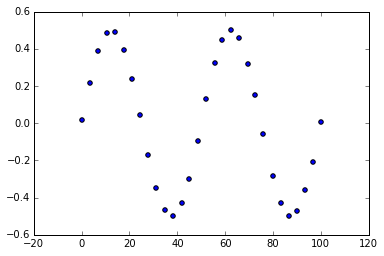

In [265]:
plt.scatter(data_t, data_rv);

## Setting up simulation
This implementation is very slow (does about 5 times more work than necessary).

In [266]:
def simulation(param):
    cart,coord = param
    r.reset()
    r.add(m=1.)
    r.add(x=cart[0],y=cart[1],z=cart[2],vx=cart[3],vy=cart[4],vz=cart[5])
    r.init_megno(0.)
    p = r.particles
    
    delta = 1e-6
    if coord==0:
        p[3].x = delta
    if coord==1:
        p[3].y = delta
    if coord==2:
        p[3].z = delta
    if coord==3:
        p[3].vx = delta
    if coord==4:
        p[3].vy = delta
    if coord==5:
        p[3].vz = delta
    
    sim_rv = np.zeros(data_N)
    sim_rvd = np.zeros(data_N)
    for i,t in enumerate(data_t):
        r.integrate(t)
        sim_rv[i]  = -(p[1].vx)
        sim_rvd[i] = -(p[1].vx+p[3].vx)
    err  = np.sum(np.square(np.subtract(sim_rv,data_rv)))
    errd = np.sum(np.square(np.subtract(sim_rvd,data_rv)))
    return err, (errd-err)/delta, sim_rv

In [267]:
def sim_array(param):
    gradient = np.zeros(6)
    for i in range(0,6):
        err, der, sim_rv =  simulation((param,i))
        gradient[i] = der
    return err, gradient, sim_rv

## Gradient descent to find minimum

In [268]:
gamma = 0.000005
a = np.array([4.5,0.,0.,0.,0.5,0.]) # initial parameters
sim_rvs = []             # for plotting
errs = []
for i in range(100): 
    err, gradient, sim_rv = sim_array(a)
    sim_rvs.append(sim_rv)
    errs.append(err)
    a = np.subtract(a,gamma*gradient)

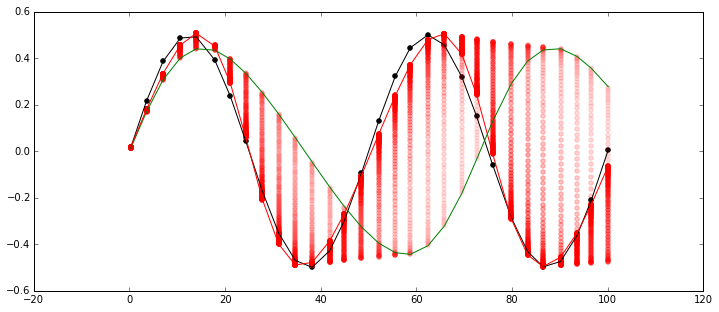

In [269]:
fig = plt.figure(figsize=(12,5))
plt.scatter(data_t, data_rv, color="k");
plt.plot(data_t, data_rv, color="k");
plt.plot(data_t, sim_rvs[0],color="g");
plt.plot(data_t, sim_rvs[-1],color="r");
opacity = 1.
for sim_rv in reversed(sim_rvs):
    plt.scatter(data_t, sim_rv,color="r", alpha=opacity);
    opacity *= 0.975

Black curve is data, green curve is initial guess. Red dots show the series converging towards the data. Red curve is final "fit".

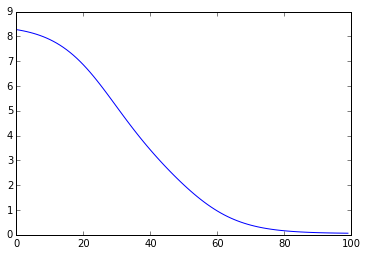

In [270]:
plt.plot(errs);